# Capacitance Model and Conductance Calculations

A Thomas-Fermi based electron density solver will be presented. The electron density for a 1D nanowire will be calculated and it will be used to construct a capacitance model. The capacitance model will be used with a Markov chain to calculate the conductance of the device.



In [1]:
# common imports

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.special # for expit function
import time

import networkx as nx
import mpmath
import itertools
import queue

## Potential Profile

The system will be assumed to extend from $x_{min} = -100$ nm to $x_{max} = 100$ nm. We will use a linear grid consisting of N_grid = 100 points.

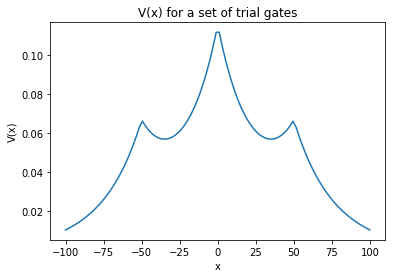

In [2]:
def calc_V_gate(x,param):
    '''
    param = [peak,mean,h,rho]
        peak : value of V at x = mean
        mean : central position of the gate
        h : height of the gate above the 2DEG
        rho : radius of the cylindrical gate
        screen : screening length in the 2DEG
        
    V(x-mean) = peak/log(h/rho) * log(sqrt(h^2 + x^2)/rho)
    '''
    (peak,mean,h,rho,screen) = param
    dx = np.abs(x-mean)
    return (peak/np.log(h/rho))*np.log(np.sqrt(dx**2 + h**2)/rho)*np.exp(-dx/screen)

def calc_V(x,gates):
    return np.sum(np.array([calc_V_gate(x,gate) for gate in gates]),axis=0) 

N_grid = 100
x = np.linspace(-100,100,N_grid)

# trial potential profile
param1 = [100e-3,0,50,5,25]
param2 = [50e-3,-50,50,5,25]
param3 = [50e-3,50,50,5,25]
trial_gates = [param1,param2,param3] 

V = calc_V(x,trial_gates)

plt.plot(x,V)
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title("V(x) for a set of trial gates");

# Thomas-Fermi Solver 

The electron density (per unit length) $n(x)$ at each point is calculated using an integral over density of states and the Fermi distribution function.

\begin{equation} n(x) = \int_0^{\infty} \frac{g(E) dE}{\exp{(\beta(E - \mu(x))} + 1} \end{equation}

The density of states is constant for a 2DEG. 

The chemical potential is offset from the Fermi energy $E_F$ because of (i) the external potential $V(x)$ and (ii) the potential generated due to the Coulomb interaction of $n(x)$. Hence, 

$$\mu(x) = E_F - e V(x) + \int_{x_{min}}^{x_{max}} K(x,x') n(x') dx'$$, 

where $K(x,x') = \frac{e^2}{4 \pi \epsilon_0 \sqrt{(x-x')^2 + \sigma^2}}$. $\sigma$ is a softening parameter to avoid blowup at $x = x'$. It is set equal to $1 nm$. 

From the above definition of $\mu(x)$, it depends on the electron density because of the Coulomb interaction. Hence, $n(x)$ has to be calculated self-consistently.

In [112]:
class ThomasFermi():
    '''
    Thomas-Fermi routines based on the polylog function approach.
    
    '''
    def __init__(self,physics):
        '''
        physics is a dict with the revelant physics
        
        x : 1d grid 
        V : potential profile
        K_0 : strength of the Coulomb interaction
        sigma : softening paramter for Coulomb interaction matrix
        mu : chemical potential (assumed to be equal for both leads)
        D : dimension of the problem to be used in the electron density integral
        g_0 : coefficient of the density of states
        kT : temperature of the system, required for the Fermi integral
        '''
        self.physics = physics
        self.K_mat = self.calc_K_mat()

    def calc_K_mat(self):
        x = self.physics['x']
        K_0 = self.physics['K_0']
        sigma = self.physics['sigma']
        
        dx = np.sqrt((x - x[:,np.newaxis])**2 + sigma**2)
        # sigma in the numerator is added for normalisation, so that value at x = 0 is same irrespective of change
        # in sigma
        return K_0*sigma/dx

    def calc_n(self):
        V = self.physics['V']
        K_mat = self.K_mat
        D = self.physics['D']
        g_0 = self.physics['g_0']
        beta = self.physics['beta']
        mu = self.physics['mu']
        
        def polylog_f(x):
            np_polylog = np.frompyfunc(mpmath.polylog, 2, 1)
            output = -g_0*np_polylog(D-1,-np.exp(beta*x))
            # cast from mpc array to numpy array
            return np.array(list(map(lambda x : complex(x),output)))
        
        n = np.zeros(len(V))
        n_prev = np.zeros(len(V))
        phi = np.zeros(len(V))
        
        for i in range(100):
            # turn on the Coulomb over 10 steps
            if i < 10:
                phi = (i/10) * np.dot(K_mat,n)
            n_prev = n
            n = polylog_f(mu - V + phi)

            if (i > 10) and (np.linalg.norm(n - n_prev)**2 < (1e-12) * np.linalg.norm(n) * np.linalg.norm(n_prev)):
                #print("Done in",i)
                break;
        self.n = np.real(n)
        return self.n

    def calc_islands(self):
        n = self.n
        # adaptive eps makes the calculation more robust 
        n_eps = 1e-1*np.max(n)
        
        n_chop = np.array([x if x > n_eps else 0.0 for x in n])
        islands = []
        start = False
        islands_index = 0
        left = 0
        for i in range(len(n_chop)):
            if(n_chop[i] > 0.0 and not start):
                start = True
                left = i
            if(n_chop[i] == 0.0 and start):
                start = False
                islands.append([left,i - 1])
                islands_index += 1
            if((i == (len(n_chop) - 1)) and start):
                start = False
                islands.append([left,i])
                islands_index += 1
        
        # ignore the leads
        # in case the leads are absent, their absence is ignored
        
        # if left lead is present
        if(islands[0][0] == 0):
            islands.pop(0)
        
        # if right lead is present
        if(islands[-1][1] == len(n) - 1):
            islands.pop(-1)
        
        self.islands = islands
        return self.islands

    def calc_charges(self):
        n = self.n
        islands = self.islands
        
        charges = []
        for item in islands:
            charges.append(np.sum(n[item[0]:item[1]]))
        
        self.charges = np.array(charges)

        return self.charges

    def calc_cap_model(self):
        islands = self.islands
        n = self.n

        # list of charge densities for islands
        n_list = []
        for item in islands:
            n_island = np.zeros(len(n))
            n_island[item[0]:item[1]] = n[item[0]:item[1]] 
            n_list.append(n_island)
            
        V = self.physics['V']
        c_k = self.physics['c_k']
        
        def cap_func(i,j):
            energy = 0.0
            if i == j:
                energy += c_k*np.sum(n_list[i]*n_list[i]) #- np.sum(V*n_list[i])

            energy += 0.5*np.dot(np.dot(n_list[i].T,self.K_mat),n_list[j])
            return energy

        energy_matrix = np.array([cap_func(i,j) for i in range(len(n_list)) for j in range(len(n_list))])\
        .reshape((len(n_list),len(n_list)))

        # Seriously? I did not even normalise by Z_i^2 and Z_i*Z_j
        # A problem here is that Z could be zero
        # Z = self.calc_charges() + 1e-2
        # newaxis trick is used to calculate the outer product
        # inverse_cap_matrix = 2*energy_matrix/np.dot(Z[:,np.newaxis],Z[np.newaxis])
       
        # forget the Z approach
        inverse_cap_matrix = energy_matrix
        Z = self.charges
    
        cap_model = (Z,inverse_cap_matrix)
        self.cap_model = cap_model
        
        return self.cap_model 

    def calc_cap_energy(self,N_vec):
        N_vec = np.array(N_vec)
        cap_model = self.cap_model
        
        return 0.5*np.dot(np.dot((N_vec-cap_model[0]),cap_model[1]),(N_vec-cap_model[0]).T)
    
    def calc_stable_config(self):
        (Z,inverse_cap_matrix) = self.cap_model 

        N_int = [int(np.rint(x)) for x in Z]
        N_limit = 1
        dN_list = [range(max(0,x-N_limit),x+N_limit,1) for x in N_int] 
        N_list = list(itertools.product(*dN_list))

        energy_table = [self.calc_cap_energy(np.array(x)) for x in N_list]
        min_energy = min(energy_table)
        charge_configuration = N_list[energy_table.index(min_energy)]
        self.charge_configuration = np.array(charge_configuration)

        return self.charge_configuration


We now calculate the electron density and the capactitance model for a V(x) as defined above. 

The value for $K_0$ can be estimated as $ = \frac{e}{4 \pi \epsilon_0 dx} (eV)$ where $dx = 1nm$. Hence, $K_0 = 0.1 eV$. 

Note that the softening paramter $\sigma$ decides the capacitance coupling between the two islands. A higher value of sigma leads to a very flat Coulomb interaction. 

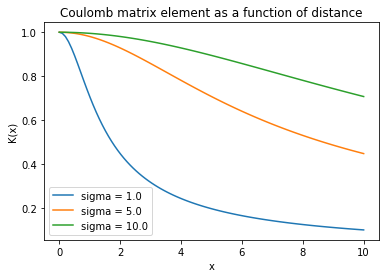

In [4]:
# profile of the Coulomb interaction with a variable softening parameter

x_test = np.linspace(0,10,100)
def K_profile(x,sigma):
    # sigma in the numerator is added for normalisation, so that all curves have the same value at x = 0
    K = sigma/np.sqrt((x**2 + sigma**2))
    return K

plt.figure(1)
plt.plot(x_test,K_profile(x_test,sigma=1.0),label="sigma = 1.0")
plt.plot(x_test,K_profile(x_test,sigma=5.0),label="sigma = 5.0")
plt.plot(x_test,K_profile(x_test,sigma=10.0),label="sigma = 10.0")
plt.xlabel('x')
plt.ylabel('K(x)')
plt.title('Coulomb matrix element as a function of distance')
plt.legend()

islands [[31, 45], [55, 69]]
charges [ 3.61530152  3.62000648]
cap_model (array([ 3.61530152,  3.62000648]), array([[ 0.00116404,  0.        ],
       [ 0.        ,  0.00116467]]))
cap matrix [[ 859.07365811    0.        ]
 [   0.          858.6104212 ]]
stable_config [4 4]


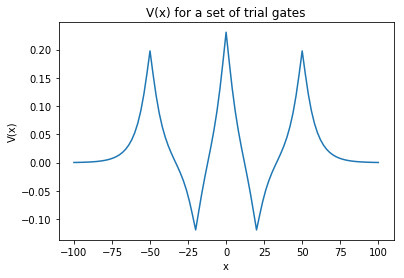

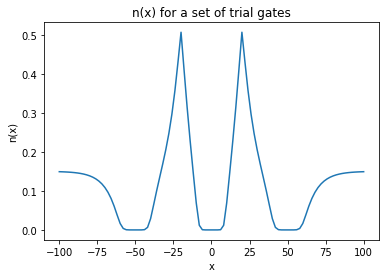

In [117]:
# trial potential profile
x = np.linspace(-100,100,101,endpoint=True)
V_g = -140e-3
h = 5 
screen = 10
rho = 100

param1 = [250e-3,0,h,rho,screen]
param2 = [200e-3,-50,h,rho,screen]
param3 = [200e-3,50,h,rho,screen]
param4 = [V_g,-20,h,rho,screen]
param5 = [V_g,20,h,rho,screen]
trial_gates = [param1,param2,param3,param4,param5] 

V = calc_V(x,trial_gates)

physics = {'x' : x,
           'V' : V,
           'K_0' : 0e-2, 
           'sigma' : 5.0,
           'mu' : 0.05,
           'D' : 2,
           'g_0' : 3e-2,
           'c_k' : 1e-3,
           'beta' : 100,
           'kT' : 1e-5,
           }

tf = ThomasFermi(physics)
n = tf.calc_n()
islands = tf.calc_islands()
charges = tf.calc_charges()
cap_model = tf.calc_cap_model()
stable_config = tf.calc_stable_config()

print("islands",islands)
print("charges",charges)
print("cap_model",cap_model)
print("cap matrix",np.linalg.inv(cap_model[1]))
print("stable_config",stable_config)

plt.figure(1)
plt.plot(x,V)
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title("V(x) for a set of trial gates");

plt.figure(2)
plt.plot(x,n)
plt.xlabel('x')
plt.ylabel('n(x)')
plt.title("n(x) for a set of trial gates");

A double dot is defined using 5 gates. The gates $d1$ and $d2$ control the depth of the potential well defining the islands. Changing the depth of the well changes the number of electrons on the dot. Hence, a map of charge vs $V_{d1}$ and $V_{d2}$ produces a charge stability diagram.



Time 10.08591890335083


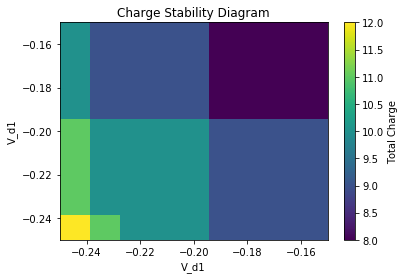

In [186]:
N_v = 10
Vd1_vec = np.linspace(-150e-3,-250e-3,N_v)
Vd2_vec = np.linspace(-150e-3,-250e-3,N_v)

# list_list_b is a list of the possible set of gate voltages which is later converted into a potential profile
list_list_b = [[param1,param2,param3] + [[a,-20,h,rho,screen],[b,20,h,rho,screen]] for a in Vd1_vec for b in Vd2_vec]

st = time.time()
tf = ThomasFermi(physics) 

def wrapper(V):
    tf.physics['V'] = V 
    n = tf.calc_n()
    islands = tf.calc_islands()
    charges = tf.calc_charges()
    cap_model = tf.calc_cap_model()
    stable_config = tf.calc_stable_config()
    return stable_config

charge_config = [wrapper(calc_V(x,y)) for y in list_list_b]
print("Time",time.time()-st)

XX,YY = np.meshgrid(Vd1_vec,Vd2_vec)
plt.pcolor(XX,YY,np.array([np.sum(x) for x in charge_config]).reshape((N_v,N_v)));
plt.xlabel('V_d1')
plt.ylabel('V_d1')
cbar = plt.colorbar()
cbar.set_label("Total Charge")
plt.title('Charge Stability Diagram')

Now that we can produce a capacitance model given a point in the gate space, we can define a Markov chain 
between the possible charge states.

The probablity distribution of the Markov chain can be used to calculate the current through the dot.

In [231]:
# graph routines
class Markov():
    '''
    Class Markov is used for graph creation and calculation of currents.
    '''
    def __init__(self,tf):
        self.tf = tf
        self.graph_model = (1,1)
        # include the leads as well
        self.start_node = tuple([0] + list(self.tf.calc_stable_config()) + [0])

    def check_validity(self,u):
        '''
        Input:
            u : node to check validity of

        Output:
            True/False

        0 : Whether the physics can support such a charge state
        False if InvalidChargeException is raised.
        Constraints:
        1. 0 <= abs(N_D - start_node) <= p
        2. abs(N_L-N_R) <= q
        3. N_L + N_D + N_R = sum(start_node)
        4. N_D >= 0
        '''
        (p,q) = self.graph_model

        N_d = u[1:-1]
        
        cond1 = True
        cond4 = True 
        num_dots = len(u) - 2
        for i in range(1,num_dots+1):
            cond1 = cond1 and (np.abs(u[i] - self.start_node[i]) <= p)
            cond4 = cond4 and (u[i] >= 0)

        cond2 = (abs(u[0] - u[-1]) <= q)

        cond3 = (np.sum(u) == np.sum(np.array(self.start_node)))

        return (cond1 and cond2 and cond3 and cond4)
    def generate_neighbours(self,v):
        '''
        Input:
            v : node to find neighbours of
        Output:
            valid : valid set of neighbours v in the graph
        '''
        neigh = []
        num_dots = len(v) - 2 

        # handling the single barrier case
        if num_dots == 0:
            # in this case, v = (0,1) or (1,0)
            # so the only other case is given by reverse of v
            neigh.append(v[::-1])
            return neigh

        for i in range(1,num_dots+1):
            # 4 possible neighbours of each change in dot charge state, ld,l,rd,r 
            # the nomenclature stems from d : dagger, so ld denotes create an electron in the left and so on

            # typecasting between arrays and tuples involved here, since the nodes are stored as tuples, whereas tuples do not support item assignment
            ld = np.array(v)
            l = np.array(v)
            rd = np.array(v)
            r = np.array(v)

            ld[i - 1] += 1
            ld[i] += -1 
            neigh.append(tuple(ld))

            l[i - 1] += -1
            l[i] += 1 
            neigh.append(tuple(l))

            rd[i + 1] += 1
            rd[i] += -1 
            neigh.append(tuple(rd))

            r[i + 1] += -1
            r[i] += 1 
            neigh.append(tuple(r))

        return neigh

    def fermi(self,E,kT):
        '''
        Input:
            E : energy (eV)
            kT : temp in eV

        Output:
            fermi_function
        '''
        return scipy.special.expit(-E/kT)


    def find_weight(self,u,v):
        '''
        Input:
            u : start node
            v : end node

        Output:
            weight : weight of edge from u to v
        '''
        set_list_L = [[1,-1,0,0],[0,0,1,-1]]
        set_list_D = [[0,1,-1,0],[0,-1,1,0]]
        set_list_R = [[-1,1,0,0],[0,0,-1,1]]
        
        t_L = 1.1
        t_D = 1.0
        t_R = 1.0
        
        if(u[1:-1] == v[1:-1]):
            # bias
            # right to left transport
            if v[0] == (u[0] + 1):
                weight = 10
                nx.set_node_attributes(self.G,"battery_node",{u : True})
            else: 
                #nx.set_node_attributes(self.G,"battery_node",{u : True})
                weight = 0
        # determine if the transition if actually Single electron transfer
        elif (list(np.array(u)-np.array(v)) in set_list_L):
            N_dot_1 = u[1:-1] 
            E_1 = self.tf.calc_cap_energy(N_dot_1)
            N_dot_2 = v[1:-1] 
            E_2 = self.tf.calc_cap_energy(N_dot_2)
            
            kT = self.tf.physics['kT']
            diff_mu = v[0]-u[0] + v[-1] - u[-1]
            simple_prob = self.fermi(E_2 - E_1 - diff_mu*0.05 ,kT)
            

            weight = t_L*simple_prob
        elif (list(np.array(u)-np.array(v)) in set_list_D):
            N_dot_1 = u[1:-1] 
            E_1 = self.tf.calc_cap_energy(N_dot_1)
            N_dot_2 = v[1:-1] 
            E_2 = self.tf.calc_cap_energy(N_dot_2)
            
            kT = self.tf.physics['kT']
            diff_mu = v[0]-u[0] + v[-1] - u[-1]
            simple_prob = self.fermi(E_2 - E_1 - diff_mu*0.05 ,kT)
            

            weight = t_D*simple_prob
        elif (list(np.array(u)-np.array(v)) in set_list_R):
            N_dot_1 = u[1:-1] 
            E_1 = self.tf.calc_cap_energy(N_dot_1)
            N_dot_2 = v[1:-1] 
            E_2 = self.tf.calc_cap_energy(N_dot_2)
            
            kT = self.tf.physics['kT']
            diff_mu = v[0]-u[0] + v[-1] - u[-1]
            simple_prob = self.fermi(E_2 - E_1 - diff_mu*0.05 ,kT)
            

            weight = t_R*simple_prob
        else:
            weight = 0
        
        return weight

    def get_battery_nodes(self):
        '''
        Input:
        Output:
            battery_ind : list of battery nodes
        '''
        # battery
        # TODO: Find a better way to find the indices for the battery edges
        battery_nodes = nx.get_node_attributes(self.G,'battery_node')
        nodes = list(self.G.nodes())
        battery_ind = []
        # find the keys of the battery nodes
        for key in battery_nodes:
            battery_ind += [nodes.index(key)]

        self.battery_ind = battery_ind
        
    def generate_graph(self):
        '''
        Input:
        Output:
            G : Markov graph of the charge states, weights assigned to edges using the energy method at zero bias, battery edges are added according to the battery weight paramter in physics input

        '''
        self.G = nx.DiGraph() 

        def generate_battery_node(n):
            b_node = np.array(n)
            # flip the electrons through the battery
            b_node[0] = n[-1]
            b_node[-1] = n[0]
            return tuple(b_node)
       
        v = self.start_node
        self.G.add_node(v)
        
        #single neighbour strategy
        neigh = self.generate_neighbours(v)
        
        for n in neigh:
            self.G.add_node(n)
            #bat_node = generate_battery_node(n)
            #self.G.add_node(bat_node)
       
        n_plus1 = tuple([-1] + list(np.array(v)[1:-1] + 1) + [-1])
        n_minus1 = tuple([1] + list(np.array(v)[1:-1] - 1) + [1])
        self.G.add_node(n_plus1)
        self.G.add_node(n_minus1)
       
        for x in self.G.nodes():
            for y in self.G.nodes():
                if (x != y):
                    w = self.find_weight(x,y)
                    self.G.add_edge(x,y,weight=w)
        
        self.get_battery_nodes()
        #import pdb;pdb.set_trace()
        # get the stable prob distribution
        self.get_prob_dist()

    def get_prob_dist(self):
        '''
        Output:
            dist : prob normalised nullspace vector of M
        '''
        # Adjacency matrix, caution not the Markov matrix
        A = np.array(nx.to_numpy_matrix(self.G))
        
        # look at this carefully
        M =  A.T - np.diag(np.sum(A,axis=1))
        
        # new approach to find the normalised probability distribution, rows of M are linearly dependent, 
        # instead replace last row with a prob normalisation condition
        M_solver = np.append(M[:-1,:],[np.ones(M.shape[0])]).reshape(M.shape) 
        b = np.zeros(M.shape[0])
        b[-1] = 1
        
        self.dist = np.linalg.solve(M_solver,b)
            
        return self.dist

    def calc_current(self):
        '''
        Input:
        Output:
            current : current 

        The basic idea is to create a Markov evolution matrix from the weights. The stable probability distribution is given as the nullspace of this matrix.

        The current is calculated by summing over the probabilities at the beginning of the battery edges.
        '''
        # calculate the current by summing over the probabities over the battery nodes 
        current = 0
        for b_ind in self.battery_ind:
            current += self.dist[b_ind]
        self.current = current
        
        # new brute way for current
        current = 0
        for x in self.G.nodes():
            for y in self.G.nodes():
                if list(np.array(y) - np.array(x)) == [1,-1,0,0]:
                    index_x = self.G.nodes().index(x)
                    current += self.dist[index_x]*self.G[y][x]["weight"]
                elif list(np.array(y) - np.array(x)) == [-1,1,0,0]:
                    index_x = self.G.nodes().index(x)
                    current += -self.dist[index_x]*self.G[y][x]["weight"]
        self.current = current
        return self.current               
    

    def calc_state(self):
        '''
        Output:
            Node with highest occupation probability
        '''
        nodes = list(self.G.nodes())
        max_prob_index = np.argmax(self.dist)
        # remove the leads
        state = nodes[max_prob_index][1:-1]
        
        # using the average charge strategy
        #state = np.sum(np.array([x*np.array(y) for (x,y) in zip(self.dist,nodes)]),axis=0)[1:-1]
        
        self.state = state
        return self.state

A Markov chain is created using the graph routines defined as above. The stable charge configuration and the conductance are calculated.

Time 65.55976295471191


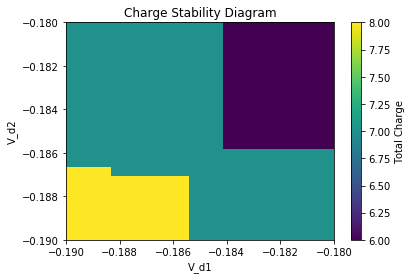

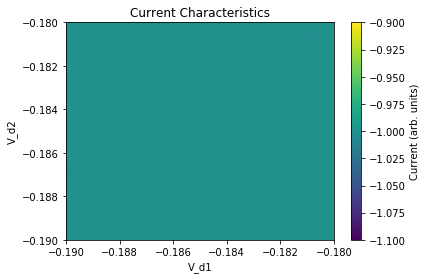

In [232]:
N_v = 25
Vd1_vec = np.linspace(-180e-3,-190e-3,N_v)
Vd2_vec = np.linspace(-180e-3,-190e-3,N_v)

# list_list_b is a list of the possible set of gate voltages which is later converted into a potential profile
list_list_b = [[param1,param2,param3] + [[a,-20,h,rho,screen],[b,20,h,rho,screen]] for a in Vd1_vec for b in Vd2_vec]
physics['kT'] = 1e-4
physics['K_0'] = 1e-4

st = time.time()
tf = ThomasFermi(physics) 
def markov_wrapper(V):
    tf.physics['V'] = V 
    n = tf.calc_n()
    islands = tf.calc_islands()
    charges = tf.calc_charges()
    cap_model = tf.calc_cap_model()
    stable_config = tf.calc_stable_config()
    markov = Markov(tf)
    
    markov.generate_graph()
    current = markov.calc_current()
    state = markov.calc_state()
    
    return state,current

output = [markov_wrapper(calc_V(x,y)) for y in list_list_b]
print("Time",time.time()-st)

XX,YY = np.meshgrid(Vd1_vec,Vd2_vec)

plt.figure(1)
plt.pcolor(XX,YY,np.array([np.sum(x[0]) for x in output]).reshape((N_v,N_v)));
plt.xlabel('V_d1')
plt.ylabel('V_d2')
cbar = plt.colorbar()
cbar.set_label("Total Charge")
plt.title('Charge Stability Diagram')

plt.figure(2)
plt.pcolor(XX,YY,np.array([x[1] for x in output]).reshape((N_v,N_v)));
plt.xlabel('V_d1')
plt.ylabel('V_d2')
cbar = plt.colorbar()
cbar.set_label("Current (arb. units)")
plt.title('Current Characteristics')

In [178]:
%pdb

Automatic pdb calling has been turned OFF


In [ ]:
output

In [ ]:
x